# Load data

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [2]:
from datasets import load_dataset

dataset = load_dataset("mllab/alfafood")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3346 [00:00<?, ? examples/s]

# Preprocessing


In [3]:
import os
import cv2
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from PIL import Image, ImageFile, ImageFont, ImageDraw, ImageEnhance
ImageFile.LOAD_TRUNCATED_IMAGES = True

import copy
from time import time

import warnings
warnings.filterwarnings('ignore')

FUSED_SHAPE = (640, 480)
ORIGINAL_SHAPE = (4000, 3000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def fused_bbox(bboxes, original_shape, fused_shape):

    x_fused = fused_shape[0] / original_shape[0]
    y_fused = fused_shape[1] / original_shape[1]

    for i in range(len(bboxes)):
        bboxes[i][0] = bboxes[i][0] * x_fused
        bboxes[i][1] = bboxes[i][1] * y_fused
        bboxes[i][2] = bboxes[i][2] * x_fused
        bboxes[i][3] = bboxes[i][3] * y_fused

    return bboxes

In [5]:
images = [dataset['train'][i]['image'].resize(FUSED_SHAPE) for i in range(len(dataset['train']))]
objects = [dataset['train'][i]['objects'] for i in range(len(dataset['train']))]

for i in range(len(objects)):
    if objects[i]['bbox'] != []:
        objects[i]['bbox'] = fused_bbox(objects[i]['bbox'], dataset['train'][i]['image'].size, FUSED_SHAPE)

In [6]:
set(i for ob in objects for i in ob['categories'])

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128}

# Prepare Dataset

In [7]:
class AlfaFoodDataset(Dataset):
    def __init__(self, images: List, objects: List[Dict[str, List]], transform: torchvision.transforms=None) -> None:
        self.images = images
        self.annotations = copy.deepcopy(objects)
        self.transform = transform
        self.num_classes = len(set(i for ob in objects for i in ob['categories']))
        self.list_transforms = np.zeros(shape=(len(self.images),))

        for i in range(len(self.annotations)):
            self.bboxes = self.annotations[i]['bbox']
            for bbox in self.bboxes:
                bbox[2] += bbox[0]
                bbox[3] += bbox[1]


    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Tuple[Tuple[int]], Tuple[int]]:
        "Returns one sample of data: image, labels, bboxes"

        image = np.array(self.images[index].convert('RGB'))
        bboxes = self.annotations[index]['bbox']
        labels = self.annotations[index]['categories']

        if self.transform:
            # print(image.shape)
            transformed = self.transform(image = image, bboxes = bboxes, labels = labels)
            image = np.array(transformed['image']).transpose(1, 2, 0)
            bboxes = transformed['bboxes']
            labels = transformed['labels']

            self.list_transforms[index] = 1
        image = image.transpose(2, 0, 1)
        target = dict()
        target['boxes'] = torch.as_tensor(bboxes, dtype=torch.float)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)

        if target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.Tensor([0, 0, 1e-10, 1e-10]).unsqueeze(dim=0)
        if target['labels'].shape == torch.Size([0]):
            target['labels']= torch.zeros(size=(1, ), dtype=torch.int64)
        return image, target


    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)

# Visualization bounding boxes with labels

In [8]:
data = AlfaFoodDataset(images, objects)

img, target = data[8]
print(img.shape)

(3, 480, 640)


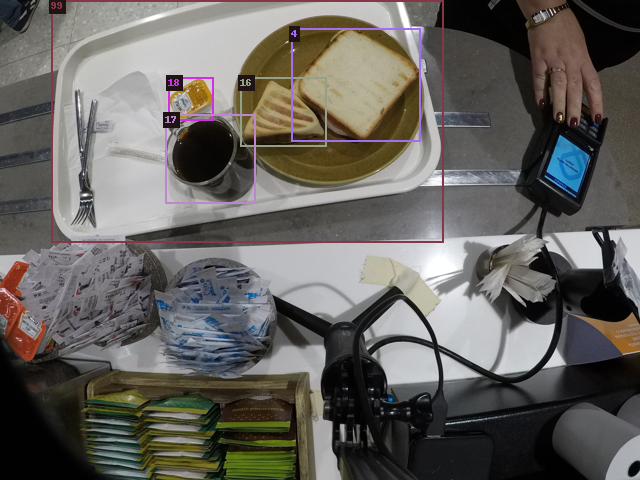

In [9]:
color = list((random.randint(40, 240), random.randint(40, 255), random.randint(60, 255)) for i in range(129))

def objects_threshold_scores(bboxes: torch.Tensor, 
                         labels: torch.Tensor=None, 
                         scores: torch.Tensor=None,
                         threshold_score: float=0.5):
    bboxes_copy = copy.deepcopy(bboxes)
    labels_copy = copy.deepcopy(labels)
    scores_copy = copy.deepcopy(scores)

    bboxes = torch.Tensor()
    labels, scores = list(), list()
    for i, score in enumerate(scores_copy):
        if score >= threshold_score:
            bboxes = torch.cat((bboxes, bboxes_copy[i]), dim=0)
            labels.append(labels_copy[i])
            scores.append(score)
    
    bboxes = bboxes.unsqueeze(dim=0)
    labels = torch.Tensor(labels)
    scores = torch.Tensor(scores)

    del bboxes_copy, labels_copy, scores_copy

    return bboxes, labels, scores

def show_image_with_objects(image: np.array, 
                            bboxes: torch.Tensor, 
                            labels: torch.Tensor=None, 
                            scores: torch.Tensor=None,
                            threshold_score: float=0.5):

    image = Image.fromarray(image.transpose(1, 2, 0))

    color = list((random.randint(40, 240), random.randint(40, 255), random.randint(60, 255)) for i in range(100))

    random.shuffle(color)

    if scores != None:
        bboxes, labels, scores = objects_threshold_scores(bboxes, labels, scores, threshold_score)

    for i in range(len(bboxes)):
        draw = ImageDraw.Draw(image)
        draw.rectangle(bboxes[i].numpy(), outline = color[i], width=2)

        if scores != None:
            bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"{labels[i]} {scores[i] * 100:.2f}%")
            draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(30, 20, 20))
            draw.text((bboxes[i][0], bboxes[i][1]), f"{labels[i]} {scores[i] * 100:.2f}%", color[i])
        else:
            bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"{labels[i]}")
            draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(30, 20, 20))
            draw.text((bboxes[i][0], bboxes[i][1]), f"{labels[i]}", color[i])
    return image

show_image_with_objects(img, target['boxes'], target['labels'])

# Prepare the transformation for augmentations

In [10]:
train_transform = albumentations.Compose(
    [
        albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Rotate(p=0.5),
        albumentations.Blur(p=0.01),
        albumentations.CLAHE(p=0.01),
        albumentations.ToGray(p=0.01),
        albumentations.MedianBlur(p=0.01),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

test_transform = albumentations.Compose(
    [
        albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

# Separation of data into training, validation and test samples

In [11]:
train_data, test_data = train_test_split(list(zip(images, objects)), test_size=0.3, shuffle=True, random_state=42)
val_data, data_data = train_test_split(test_data, test_size=0.3, shuffle=True, random_state=42)

train_data = AlfaFoodDataset(images=list(items[0] for items in train_data),
                             objects=list(items[1] for items in train_data),
                             transform=train_transform )

test_data = AlfaFoodDataset(images=list(items[0] for items in test_data),
                            objects=list(items[1] for items in test_data),
                            transform=test_transform )

val_data = AlfaFoodDataset(images=list(items[0] for items in val_data),
                           objects=list(items[1] for items in val_data),
                           transform=test_transform )

(3, 480, 640)


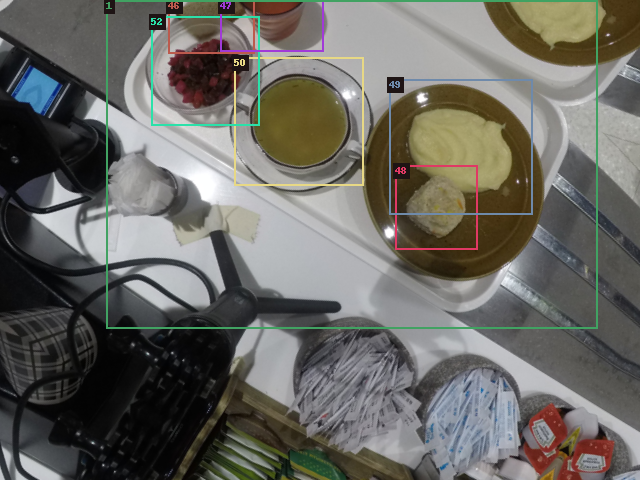

In [12]:
img, target = train_data[5]
print(img.shape)
show_image_with_objects(img, target['boxes'], target['labels'])

# Create Dataloaders

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=4,
                                               shuffle=True,
                                               num_workers=os.cpu_count(),
                                               collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                                             batch_size=2,
                                             shuffle=False,
                                             num_workers=os.cpu_count(),
                                             collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=2,
                                              shuffle=False,
                                              num_workers=os.cpu_count(),
                                              collate_fn=collate_fn)

# Create model

In [14]:
class FasterRCNN_ResNet50(torch.nn.Module):
  def __init__(self, num_classes: int=127) -> None:
    super().__init__()

    self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
    num_classes = num_classes + 2
    in_features = self.model.roi_heads.box_predictor.cls_score.in_features
    self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    for child in list(self.model.children())[:-3]:
      for param in child.parameters():
          param.requires_grad = False

  def predict(self, X: torch.Tensor) -> torch.Tensor:
    '''
    For predict bboxes and labels
    '''
    return self.model(X)

  # To calculate the loss function
  def forward(self, images: List[torch.Tensor], annotation: List[Dict[str, torch.Tensor]]) -> Dict[str, int]:
    return self.model(images, annotation)

model = FasterRCNN_ResNet50(num_classes=data.num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 142MB/s]


# Function for calculate IoU metrics

In [15]:
def get_IoU(bbox1: torch.Tensor, bbox2: torch.Tensor) -> float:
  x_left = max(bbox1[0], bbox2[0])
  x_right = min(bbox1[2], bbox2[2])

  y_bottom = max(bbox1[1], bbox2[1])
  y_top = min(bbox1[3], bbox2[3])

  intersection_bboxes = (y_top - y_bottom) * (x_right - x_left)
  union_bboxes = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1]) + \
                 (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1]) - intersection_bboxes

  return intersection_bboxes / union_bboxes

assert(get_IoU(target['boxes'][0], target['boxes'][0]) == 1)

# Declare functions for training, validation and testing

In [16]:
def train_step(device: torch.device,
               model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module = None,
               scheduler: torch.optim.lr_scheduler = None):

  model.to(device)
  model.train()

  train_loss = 0
  torch.cuda.empty_cache()

  time_epoch_start = time()

  for batch, (images, annotations) in enumerate(dataloader):

    images = [torch.Tensor(image).to(device) for image in images]
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    if criterion == None:
      loss_dict = model(images, annotations)
      loss = sum(loss for loss in loss_dict.values())
    else:
      pass
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if scheduler is not None:
      scheduler.step()

    # print(f"LOSSES: {loss}")
    # print(model(images[0]))

  train_loss = train_loss / len(dataloader)
  time_epoch_end = time() - time_epoch_start

  return train_loss, time_epoch_end



@torch.no_grad()
def validation_step(device: torch.device,
                    model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    criterion: torch.nn.Module = None):
  model.to(device)
  model.eval()

  val_loss = 0
  min_val_loss = 1e6
  torch.cuda.empty_cache()

  time_epoch_start = time()
  with torch.inference_mode():
    for batch, (images, annotations) in enumerate(dataloader):

      images = [torch.Tensor(image).to(device) for image in images]
      annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

      if criterion == None:
        model.train()
        loss_dict = model(images, annotations)
        # print(loss_dict)
        loss = sum(loss for loss in loss_dict.values())
        model.eval()
      else:
        pass
      val_loss += loss.item()

      # print(f"TESTING MODEL {model.predict(images)}")
      # break
      # print(f"LOSSES: {loss}")

  val_loss /= len(dataloader)
  time_epoch_end = time() - time_epoch_start

  # val_loss = validate(epoch)
  if val_loss < min_val_loss:
      print('NEW BEST MODEL!')
      torch.save(model.state_dict(), 'best_model.pth')
      min_val_loss = val_loss
  torch.save(model.state_dict(), 'latest_model.pth')

  return val_loss, time_epoch_end



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device):
  for epoch in tqdm(range(epochs)):
    train_loss, train_train_epoch = train_step(model=model,
                                        dataloader=train_dataloader,
                                        optimizer=optimizer,
                                        device=device)

    print(f"EPOCH: {epoch+1} | TRAIN LOSS: {train_loss} | TRAIN TIME: {train_train_epoch}")

    val_loss, val_time_epoch = validation_step(model=model,
                                          dataloader=test_dataloader,
                                          device=device)

    print(f"EPOCH: {epoch+1} | VAL LOSS: {val_loss} | VAL TIME: {val_time_epoch}\n")

In [17]:
# LOSSES: {'loss_classifier': tensor(141.1330, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(2.4547, grad_fn=<DivBackward0>), 'loss_objectness': tensor(133.6202), 'loss_rpn_box_reg': tensor(8.3771)}

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-7)

train(model, train_dataloader, val_dataloader, optimizer, num_epochs, device)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1 | TRAIN LOSS: 2.0826410515926805 | TRAIN TIME: 574.3159368038177
NEW BEST MODEL!
EPOCH: 1 | VAL LOSS: 1.5800325495313363 | VAL TIME: 119.91102933883667
EPOCH: 2 | TRAIN LOSS: 1.4544611171447377 | TRAIN TIME: 576.9213058948517
NEW BEST MODEL!
EPOCH: 2 | VAL LOSS: 1.3613146930576796 | VAL TIME: 120.52804374694824
EPOCH: 3 | TRAIN LOSS: 1.2966836783462823 | TRAIN TIME: 577.4759430885315
NEW BEST MODEL!
EPOCH: 3 | VAL LOSS: 1.2843106178885912 | VAL TIME: 120.25739526748657
EPOCH: 4 | TRAIN LOSS: 1.3161266798045448 | TRAIN TIME: 577.9766292572021
NEW BEST MODEL!
EPOCH: 4 | VAL LOSS: 1.3254294212595874 | VAL TIME: 120.59021282196045
EPOCH: 5 | TRAIN LOSS: 1.3358536726785601 | TRAIN TIME: 579.2390565872192
NEW BEST MODEL!
EPOCH: 5 | VAL LOSS: 1.357159296473659 | VAL TIME: 120.70890951156616
EPOCH: 6 | TRAIN LOSS: 1.2626204255701332 | TRAIN TIME: 578.6754863262177
NEW BEST MODEL!
EPOCH: 6 | VAL LOSS: 1.289125805713266 | VAL TIME: 120.33440136909485
